In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch import nn
from torch import optim
from torchvision import transforms
from torchvision import models
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import os, sys, time, random
from torch.autograd import Variable
import matplotlib.patches as patches

from PIL import Image, ImageFilter
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_erosion, square
from datetime import datetime

# Training NN

In [2]:
batch_size = 50
my_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()])

train_dir = "data/train"
val_dir = "data/val"

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform = my_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform = my_transforms)

trainloader = DataLoader(train_dataset,batch_size = 200, shuffle = True, num_workers = 0)
valloader = DataLoader(val_dataset,batch_size = batch_size, shuffle = True, num_workers = 0)

In [6]:
def train_model(model_ft,loss_fn,optimizer,PATH,max_epochs=51):
    Loss_History = []
    Accuracy_History = []
    Validation_Accuracy_History = []
    Validation_Loss_History = []
    Max_Validation_Accuracy = -1
    Max_Validation_Epoch = -1
    Test_Accuracy_History = []

    for epoch in range(max_epochs):
        model_ft.train()
        Running_Loss = 0
        Image_Count = 0
        Epoch_Accuracy = 0
        Image_Count = 0

        #TRAINING PHASE
        for i,(inputs,labels) in enumerate(trainloader):
            Image_Count += 1
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            optimizer.zero_grad()
            output = model_ft(inputs)
            loss = loss_fn(output,labels)
            Running_Loss += loss.data.item()
            loss.backward()
            optimizer.step()
            
            _ , Predictions = torch.max(output.data,1)
            Correct_Counts = Predictions.eq(labels.data.view_as(Predictions)).sum()
            Accuracy = Correct_Counts.float()/labels.shape[0]
            Epoch_Accuracy+=Accuracy.item()
            clear_output(True)
            print(f"||TRAINING|| Epoch: {epoch} | Batch: {i+1}/{len(trainloader)} | T_Loss: {loss.data.item():.5f} | T_Accuracy: {(100*Accuracy):.2f}%")
            
        Loss_History.append(Running_Loss/Image_Count)
        Accuracy_History.append(Epoch_Accuracy/len(trainloader))
        
        #VALIDATION
        model_ft.eval()
        Validation_Loss = 0
        Validation_Accuracy = 0

        with torch.no_grad():
            Image_Count = 0
            for i,(inputs, labels) in enumerate(valloader):
                Image_Count += 1
                inputs = inputs.to(device)
                labels = labels.type(torch.LongTensor).to(device)
                outputs = model_ft(inputs)
                loss = loss_fn(outputs,labels)
                Validation_Loss += loss.data.item()

                _ , Predictions = torch.max(outputs.data,1)
                Correct_Counts = Predictions.eq(labels.data.view_as(Predictions)).sum()
                Accuracy = Correct_Counts.float()/labels.shape[0]
                Validation_Accuracy+=Accuracy.item()
                clear_output(True)
                print(f"||VALIDATING|| Epoch: {epoch} | Batch: {i+1}/{len(valloader)} | V_Loss: {loss.data.item():.5f} | V_Accuracy: {(100*Accuracy):.2f}%")
            
            if (Validation_Accuracy/len(valloader))>=Max_Validation_Accuracy:
                Max_Validation_Accuracy = Validation_Accuracy/len(valloader)
                Max_Validation_Epoch = epoch
                torch.save(model_ft,PATH)

            Validation_Loss_History.append(Validation_Loss/Image_Count)
            Validation_Accuracy_History.append(Validation_Accuracy/len(valloader))
    
    #PLOTTING
    print(f"Max Validation Accuracy: {(100*np.max(Validation_Accuracy_History)):.5f}% at epoch {Max_Validation_Epoch}")
    plt.plot(np.arange(max_epochs),Loss_History,label="Training Loss")
    plt.plot(np.arange(max_epochs),Validation_Loss_History,label="Validation Loss")
    plt.legend()
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("Loss_Plot.png")
    
    plt.figure()
    plt.plot(np.arange(max_epochs),Accuracy_History,label = "Training Acc")
    plt.plot(np.arange(max_epochs),Validation_Accuracy_History,label = "Validation Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.savefig("Accuracy_Plot.png")

||VALIDATING|| Epoch: 29 | Batch: 21/21 | V_Loss: 0.00211 | V_Accuracy: 100.00%
Max Validation Accuracy: 99.61905% at epoch 29


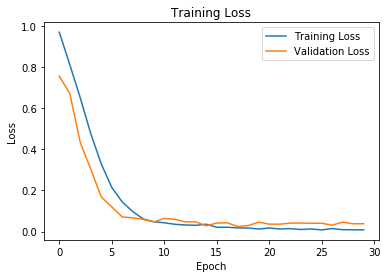

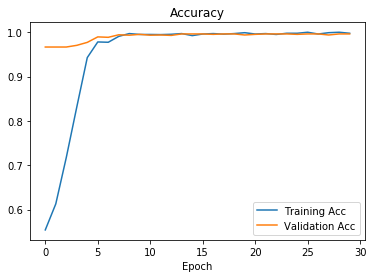

In [8]:
model_cl = models.resnet50(pretrained=True)
for param in model_cl.parameters():
    param.requires_grad = False
    
#Define fully connected layer at end to train    
num_ftrs = model_cl.fc.in_features
model_cl.fc = nn.Sequential(nn.Linear(num_ftrs, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(1024,512),
                                 nn.ReLU(),
                                 nn.Linear(512, 3),
                                 nn.LogSoftmax(dim=1))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cl.fc.parameters(), lr=0.0001)
model_cl = model_cl.to(device)

train_model(model_cl,loss_fn,optimizer,"NN_Classifier_Chess_1.pt",max_epochs=30)

# Code

In [3]:
model_ft = torch.load("NN_Classifier_Chess_1.pt")
model_ft.eval()
print()

In [4]:
#Create board
board_arr = np.zeros((8,8))
board_arr[0:2,:] = np.ones((2,8))
board_arr[6:,:] = np.ones((2,8))*2
board_map = [[],[],[],[],[],[],[],[]]
board_map[7][:] = ['a1','b1','c1','d1','e1','f1','g1','h1']
board_map[6][:] = ['a2','b2','c2','d2','e2','f2','g2','h2']
board_map[5][:] = ['a3','b3','c3','d3','e3','f3','g3','h3']
board_map[4][:] = ['a4','b4','c4','d4','e4','f4','g4','h4']
board_map[3][:] = ['a5','b5','c5','d5','e5','f5','g5','h5']
board_map[2][:] = ['a6','b6','c6','d6','e6','f6','g6','h6']
board_map[1][:] = ['a7','b7','c7','d7','e7','f7','g7','h7']
board_map[0][:] = ['a8','b8','c8','d8','e8','f8','g8','h8']

#Dataloader segments
chess_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])


def GetMove(board_arr):
    #Partition into segments
    
    
    #Take Image and save to file
    chess_dir = "data/1" #Image directory
    chess_dataset = torchvision.datasets.ImageFolder(chess_dir, transform = chess_transforms)
    chessloader = DataLoader(chess_dataset,batch_size = 1, shuffle = False, num_workers = 0)

    #Run on neural network
    new_board_state = np.zeros(64)
    confidence = np.zeros(64)
    for i,(inputs,labels) in enumerate(chessloader):
        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        outputs = model_ft(inputs)

        conf , Predictions  = torch.max(torch.nn.functional.softmax(outputs.data,dim = 1),1)
        Predictions = Predictions.cpu().numpy()[0]

        if Predictions == 0: #Black
            Detected_Piece = 1
        elif Predictions == 1:
            Detected_Piece = 0 #Empty
        else:
            Detected_Piece = 2 #White
        new_board_state[i] = Detected_Piece
        confidence[i] = conf.cpu().numpy()[0]
    new_board_state = np.reshape(new_board_state,(8,8))
    confidence = np.reshape(confidence,(8,8))

    Fromi = -1
    Fromj = -1
    Toi = -1
    Toj = -1

    for i in range(8):
        for j in range(8):
            if new_board_state[i][j]!=board_arr[i][j]:
                if new_board_state[i][j] == 0:
                    Fromi = i
                    Fromj = j
                elif new_board_state[i][j]>0:
                    Toi = i
                    Toj = j

    Result = board_map[Fromi][Fromj] + board_map[Toi][Toj]
    print(Result)
    print(new_board_state)
    board_arr = new_board_state
    return Result


In [5]:
board_arr = GetMove(board_arr)

a2h3
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2.]
 [0. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2.]]


In [20]:
# libraries

# take a picture
# FYP CV: take board images

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageDraw
from skimage.filters import threshold_otsu, sobel
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_erosion, binary_closing, square

def takePicture(fileSavePath, saveType='.bmp', noFrames=20, frameHeight=480, frameWidth=640):
    capR = cv2.VideoCapture(1)
    capCount = noFrames
    frameSetR = np.zeros((noFrames, frameHeight, frameWidth, 3))
    capR.set(cv2.CAP_PROP_FRAME_HEIGHT, frameHeight) # 480 typically
    capR.set(cv2.CAP_PROP_FRAME_WIDTH, frameWidth) # 640 typically


    while(capCount!=0):
        _, frameR = capR.read()
        if capCount > 0:
            capCount -= 1
            frameSetR[capCount] = frameR

    capR.release()

    if not cv2.imwrite(fileSavePath + 'R' + saveType, np.mean(frameSetR, axis=0)):
        raise Exception('could not save webcam image')

    return fileSavePath + 'R' + saveType

# for left camera, use img_size2 = (160, 0, 640, 480)
def partitionPicture(imagePath, saveName, savePath='', saveType='.bmp', img_size1 = (640, 480), img_size2 = (0, 0, 480, 480), boardDim = (8, 8), grayscale=True, fixLight=160):

    imgArr = LoadNFormatImg(imagePath, grayscale=grayscale, imgSize_Resize=img_size1, imgSize_Crop=img_size2)
    imgArrGS = LoadNFormatImg(imagePath, grayscale=True, imgSize_Resize=img_size1, imgSize_Crop=img_size2)
    imgArrGS = np.clip(imgArrGS + fixLight - np.mean(imgArrGS[0:50]), a_min=0, a_max=255)

    rotateAngle, imgVL, imgHL = getSquareCoords(imgArrGS, imgSize=(img_size2[2]-img_size2[0], img_size2[3]-img_size2[1]), boardDim=boardDim)
    imgArr = np.asarray(Image.fromarray(imgArr).rotate(angle=rotateAngle, fillcolor=0)).astype(np.float64)

    saveImgsCode = saveSqImgs(imgArr, imgVL, imgHL, fileSaveName=saveName, fileSavePath=savePath, fileExt=saveType, boardDim=boardDim)

    return savePath+saveName

def findMove(imagePath, sqColors=np.zeros((1,1)), sqIDataArchive=np.zeros((1,1)), sqOccupancyArchive=np.zeros((1,1)), img_size1 = (640, 480), img_size2 = (0, 0, 480, 480), boardDim = (8, 8), fixLight=160):

    imgArrGS = LoadNFormatImg(imagePath, grayscale=True, imgSize_Resize=img_size1, imgSize_Crop=img_size2)
    #imgArrGS = np.clip(imgArrGS + fixLight - np.mean(imgArrGS[0:50]), a_min=0, a_max=255)

    rotateAngle, imgVL, imgHL = getSquareCoords(imgArrGS, imgSize=(img_size2[2]-img_size2[0], img_size2[3]-img_size2[1]), boardDim=boardDim)
    imgArr = np.asarray(Image.fromarray(imgArrGS).rotate(angle=rotateAngle, fillcolor=0)).astype(np.float64)

    sqIData = getSqData(imgArr, imgVL, imgHL, sqDataType='img', boardDim=(8, 8), cropB=0)

    if sqIDataArchive.shape[1] == 1:
        sqHData = getSqData(imgArr, imgVL, imgHL, sqDataType='hist', boardDim=(8, 8), cropB=5)
        sqColors = getSqColors(sqHDataStruct=sqHData, boardDim=(8, 8))
        sqIDataArchive = sqIData.reshape((1, boardDim[0], boardDim[1], 14**2))
        sqOccupancy = np.concatenate((np.ones((2,8)), np.zeros((4,8)), 2*np.ones((2,8))), axis=0)
        sqOccupancyArchive = sqOccupancy.reshape((1,8,8))
        moveCode = '0000'
    else:
        sqOccupancy = findPieces(sqIData, sqOccupancyArchive, sqIDataArchive, sqColors)
        sqIDataArchive = np.concatenate((sqIDataArchive, sqIData.reshape((1, boardDim[0], boardDim[1], 14**2))), axis=0)
        sqOccupancyArchive = np.concatenate((sqOccupancyArchive, sqOccupancy.reshape((1, boardDim[0], boardDim[1]))), axis=0)

        if np.sum((sqOccupancyArchive[-1] > 0) & (sqOccupancy == 0)) == 1:
            desLoc = np.arange(boardDim[0]*boardDim[1])[((sqOccupancyArchive[-1] > 0) & (sqOccupancy == 0)).flatten()]
            if sqOccupancyArchive.shape[0] % 2 == 1:  # white's turn
                moveLoc = np.arange(boardDim[0]*boardDim[1])[((sqOccupancyArchive[-1] != 2) & (sqOccupancy == 2)).flatten()]
            else: # black's turn
                moveLoc = np.arange(boardDim[0]*boardDim[1])[((sqOccupancyArchive[-1] != 1) & (sqOccupancy == 1)).flatten()]
        else: # castling
            if sqOccupancyArchive.shape[0] % 2 == 1:  # white's turn
                desLoc = 4
                if sqOccupancyArchive[-1, 0, 0] == 2 and sqOccupancy[0, 0] == 0:
                    moveLoc = 2
                else:
                    moveLoc = 5
            else: # black's turn
                desLoc = 60
                if sqOccupancyArchive[-1, 7, 0] == 1 and sqOccupancy[7, 0] == 0:
                    moveLoc = 58
                else:
                    moveLoc = 62
        moveCode = formatMoveCode(desLoc, moveLoc, boardDim)

    return moveCode, sqColors, sqIDataArchive, sqOccupancyArchive


# ======================================================================
# function for loading and formatting image
def LoadNFormatImg(imagePath, grayscale=False, imgSize_Resize=(1024, 768), imgSize_Crop=(0,0,1024, 768)):

    # open image and record image size, up/downsample image to expected image size
    imgArr = np.asarray(Image.open(imagePath).resize(imgSize_Resize).crop(imgSize_Crop))

    # check number of channels, average to nChannels
    if (imgArr.shape[2] > 1) & grayscale:
        imgArr = np.mean(imgArr, axis=2)

    # return image as numpy array
    return imgArr

# ======================================================================
# function for identifying board position and scale
def getSquareCoords(imgArr, imgSize=(1024, 768), erosR=7, openR=10, bordW=80, boardDim=(8,8)):

    # calculate threshold using otsu and apply
    intensityTh = threshold_otsu(imgArr)
    imgThArr = (imgArr < intensityTh)
    #Image.fromarray(255*imgThArr.astype(np.uint8)).show()

    # morphologically erode then open binary images
    imgMorphArr = binary_opening(binary_erosion(imgThArr, selem=square(erosR)), selem=square(openR))
    #Image.fromarray(255*imgMorphArr.astype(np.uint8)).show()

    # remove border regions
    imgClearArr = clear_border(imgMorphArr, buffer_size=bordW)
    #Image.fromarray(255*imgClearArr.astype(np.uint8)).show()


    # apply connected-component labelling
    imgLabArr = label(imgClearArr)
    #Image.fromarray(55*(imgLabArr>0)+200*imgLabArr/np.max(imgLabArr).astype(np.uint8)).show()

    # remove regions of size x: median(regionSize)/2 < x < 2*median(regionSize) ---- (option: then reapply connected-component labelling?)
    regionStatsFull = regionprops(imgLabArr, coordinates="xy")
    regionStats = np.array([[region.label, region.area, region.centroid[0], region.centroid[1], region.extent] for region in regionStatsFull])
    for region in range(len(regionStats)):
        if regionStats[region, 1] < np.median(regionStats, axis=0)[1]/2 or regionStats[region, 1] > np.median(regionStats, axis=0)[1]*2:
            imgLabArr = imgLabArr * (imgLabArr != region+1)
    regionStats = regionStats[(regionStats[:, 1] >= np.median(regionStats, axis=0)[1]/2) & (regionStats[:, 1] < np.median(regionStats, axis=0)[1]*2)]
    #Image.fromarray(55*(imgLabArr>0)+imgLabArr*200/np.max(imgLabArr).astype(np.uint8)).show()

    # calculate how much to rotate image by
    angleList = []
    regionRowSort = regionStats[np.argsort(regionStats[:, 2])]
    regionRowSort = np.array([region for region in regionRowSort if region[4] >= 0.75])
    rowGapTh = np.max(regionRowSort[1:, 2]-regionRowSort[0:-1, 2])/2
    regionRowGroup = np.concatenate((np.zeros(1),np.cumsum((regionRowSort[1:, 2]-regionRowSort[0:-1, 2]) > rowGapTh)), axis=None)
    for rowGroup in range(int(np.max(regionRowGroup)+1)):
        if sum(regionRowGroup == rowGroup) > 1:
            A = np.array([[regionRowSort[region,3], 1] for region in np.arange(regionRowGroup.size)[regionRowGroup==rowGroup]])
            y = regionRowSort[np.arange(regionRowGroup.size)[regionRowGroup == rowGroup], 2]
            m, c = np.linalg.lstsq(A, y - np.mean(y), rcond=None)[0]
            angleList.append(np.arctan(m))
    regionColSort = regionStats[np.argsort(regionStats[:, 3])]
    regionColSort = np.array([region for region in regionColSort if region[4] >= 0.75])
    colGapTh = np.max(regionColSort[1:, 3]-regionColSort[0:-1, 3])/2
    regionColGroup = np.concatenate((np.zeros(1),np.cumsum((regionColSort[1:, 3]-regionColSort[0:-1, 3]) > colGapTh)), axis=None)
    for colGroup in range(int(np.max(regionColGroup)+1)):
        if sum(regionColGroup == colGroup) > 1:
            A = np.array([[regionColSort[region,3], 1] for region in np.arange(regionColGroup.size)[regionColGroup==colGroup]])
            y = regionColSort[np.arange(regionColGroup.size)[regionColGroup == colGroup], 2]
            m, c = np.linalg.lstsq(A, y - np.mean(y), rcond=None)[0]
            angleList.append(np.arctan(m)-np.pi/2)
    rotateAngle = np.median(angleList)*180/np.pi
    #Image.fromarray(55*(imgLabArr>0)+imgLabArr*200/np.max(imgLabArr).astype(np.uint8)).rotate(angle=rotateAngle, fillcolor=0).show()

    # find minimums of row sums and column sums
    imgLabArr = np.array(Image.fromarray(imgLabArr*255/np.max(imgLabArr).astype(np.uint8)).rotate(angle=rotateAngle, fillcolor=0))>0
    imgCS = np.reshape(np.sum(imgLabArr > 0, axis=0), (np.shape(imgLabArr)[1]))
    imgRS = np.reshape(np.sum(imgLabArr > 0, axis=1), (np.shape(imgLabArr)[0]))
    pECS = np.convolve(imgCS < threshold_otsu(imgCS), np.asarray([1/2, 1/2]))
    pERS = np.convolve(imgRS < threshold_otsu(imgRS), np.asarray([1/2, 1/2]))
    pEIndCS = np.asarray([i for i in range(imgSize[0]-1) if pECS[i + 1] == 1/2])
    pEIndRS = np.asarray([i for i in range(imgSize[1]-1) if pERS[i + 1] == 1/2])
    imgVL = np.asarray([pEIndCS[0]-erosR/2]+[(pEIndCS[2*i-1]+pEIndCS[2*i])/2 for i in range(1, int(len(pEIndCS)/2))]+[pEIndCS[-1]+erosR/2])
    imgHL = np.asarray([pEIndRS[0]-erosR/2]+[(pEIndRS[2*i-1]+pEIndRS[2*i])/2 for i in range(1, int(len(pEIndRS)/2))]+[pEIndRS[-1]+erosR/2])

    imgVL_Diff = imgVL[1:]-imgVL[0:-1]
    imgHL_Diff = imgHL[1:]-imgHL[0:-1]

    if imgHL_Diff.shape[0] != boardDim[0]:
        imgHL = imgHL[0] + np.median(imgHL_Diff)*np.arange(boardDim[0]+1)
    elif np.sum(np.abs(imgHL_Diff - np.median(imgHL_Diff)) > 0.2*np.median(imgHL_Diff)) > 0:
        imgHL = ((boardDim[0]*np.median(imgHL_Diff) + 3*imgHL[0] - imgHL[-1])/2) + np.median(imgHL_Diff)*np.arange(boardDim[0]+1)
    if imgVL_Diff.shape[0] != boardDim[1]:
        imgVL = imgVL[0] + np.median(imgVL_Diff)*np.arange(boardDim[1]+1)
        #imgVL[5:] += 0.01*np.median(imgVL_Diff) # to account for centre hinge
    elif np.sum(np.abs(imgVL_Diff - np.median(imgVL_Diff)) > 0.2*np.median(imgVL_Diff)) > 0:
        imgVL = (((boardDim[1]*np.median(imgVL_Diff) + 3*imgVL[0] - imgVL[-1])/2) + np.median(imgVL_Diff)*np.arange(boardDim[1]+1))

    # return imgHL and imgVL
    return rotateAngle, imgVL.astype(int), imgHL.astype(int)

# ======================================================================
# function for partitioning squares
def getSqData(imgArr, imgVL, imgHL, sqDataType, cropB=0, boardDim=(8,8)):

    if sqDataType == 'hist':

        # predefine sqHData - sqColor, sqStatus, peakLoc, imgHist
        sqHData = np.zeros((boardDim[0], boardDim[1], 3+256))

        # run through squares
        for i in range(boardDim[0]):
            for j in range(boardDim[1]):

                # find and crop squares
                sqIRaw = Image.fromarray(imgArr.astype(np.uint8), mode='L').crop((imgVL[j]+cropB, imgHL[i]+cropB, imgVL[j+1]-1-cropB, imgHL[i+1]-1-cropB))

                # calculate histograms, normalize and save to sqHData
                sqHRaw, binEdges = np.histogram(np.asarray(sqIRaw).astype(np.uint8), bins=range(256+1), density=True)
                sqHData[i,j,3:] = sqHRaw

                # find histogram peak and save index to sqHData
                sqHData[i,j,2] = np.argmax(sqHRaw)

        # return sqHData
        return sqHData

    elif sqDataType == 'fft':

        # predefine sqFFTData - sqColor, sqStatus, imgFFT
        sqFFTData = np.zeros((boardDim[0], boardDim[1], 2 + 14**2))

        # run through squares
        for i in range(boardDim[0]):
            for j in range(boardDim[1]):

                # find and crop squares
                sqIRaw = Image.fromarray(imgArr.astype(np.uint8), mode='L').crop((imgVL[j]+cropB, imgHL[i]+cropB, imgVL[j+1]-1-cropB, imgHL[i+1]-1-cropB))
                sqIRaw = sqIRaw.resize((30, 30)).crop((8, 8, 22, 22))

                # calculate FFTs and save to sqFFTData
                dataFFT = np.real(np.fft.fftshift(np.fft.fft2(np.asarray(sqIRaw).astype(int)))).flatten()
                sqFFTData[i,j,2:] = dataFFT

        # return sqHData
        return sqFFTData

    elif sqDataType == 'sobel':

        # predefine sqSobelData - sqColor, sqStatus, imgSobel
        sqSobelData = np.zeros((boardDim[0], boardDim[1], 2 + 14**2))

        # run through squares
        for i in range(boardDim[0]):
            for j in range(boardDim[1]):

                # find and crop squares
                sqIRaw = Image.fromarray(imgArr.astype(np.uint8), mode='L').crop((imgVL[j]+cropB, imgHL[i]+cropB, imgVL[j+1]-1-cropB, imgHL[i+1]-1-cropB))
                sqIRaw = sqIRaw.resize((30, 30)).crop((8, 8, 22, 22))

                # calculate Sobel edge detection and save to sqSobelData
                dataSobel = sobel(np.asarray(sqIRaw).astype(np.uint8)).flatten()
                sqSobelData[i,j,2:] = dataSobel

        # return sqHData
        return sqSobelData

    elif sqDataType == 'img':

        # predefine sqImgData - sqColor, sqStatus, imgData
        sqImgData = np.zeros((boardDim[0], boardDim[1], 14**2))

        # run through squares
        for i in range(boardDim[0]):
            for j in range(boardDim[1]):

                # find and crop squares
                sqIRaw = Image.fromarray(imgArr.astype(np.uint8), mode='L').crop((imgVL[j]+cropB, imgHL[i]+cropB, imgVL[j+1]-1-cropB, imgHL[i+1]-1-cropB))
                sqIRaw = sqIRaw.resize((30, 30)).crop((8, 8, 22, 22))

                # flatten img and save to sqSobelData
                dataImg = np.asarray(sqIRaw).astype(np.uint8).flatten()
                sqImgData[i,j,:] = dataImg

        # return sqImgData
        return sqImgData

    else:
        raise Exception('Error: did not choose output data type')

# =======================================================================
# function for square color identification
def getSqColors(sqHDataStruct, boardDim=(8,8)):

    # initialise counters
    countA, countB = 0, 0

    # run through squares
    for i in range(boardDim[0]):
        for j in range(boardDim[1]):
            # add to appropriate counter based on squareCount
            if (i + j) % 2:
                countA += sqHDataStruct[i,j,2]
            else:
                countB += sqHDataStruct[i,j,2]

    # run through squares
    for i in range(boardDim[0]):
        for j in range(boardDim[1]):
            # update sqHDataStruct with square colors
            sqHDataStruct[i,j,0] = (countA < countB) ^ ((i + j) % 2)

    # return sqHDataStruct
    return sqHDataStruct[:, :, 0]

# =======================================================================
# function for piece detection
def findPieces(sqIData, sqOccupancyArchive, sqIDataArchive, sqColors, boardDim=(8,8)):

    sqOccupancy = np.zeros(boardDim)
    sobelFocusBox = np.zeros((boardDim[0], boardDim[1], 4))
    sqFocusStat = np.zeros(boardDim)
    sobelSums = np.zeros(boardDim)
    sobel_filtLvl, sobel_satLvl = 5, 100
    sobelFocusBoxF = 1.00
    sobelStatTh = 30
    imgSumTh = 10
    moveCase = 0

    for i in range(boardDim[0]):
        for j in range(boardDim[1]):

            # generate sobel edge detection data
            sqImg = sqIData[i, j, :].reshape((14, 14))
            dataSobel = sobel(sqImg)
            #dataSobel = np.clip(dataSobel * (dataSobel > sobel_filtLvl), a_min=0, a_max=sobel_satLvl)

            if np.sum(dataSobel > sobelStatTh) > 25:
                sobel_maxEdge = binary_closing((dataSobel > sobelStatTh)[1:13, 1:13], selem=square(4))
                if np.sum(sobel_maxEdge == 0) > 0:
                    sqSobel_lab = label(sobel_maxEdge, background=0, connectivity=1)
                    sqSobel_regStat = np.asarray([np.sum((sqSobel_lab==regID)) for regID in range(1, 1 + np.max(sqSobel_lab))])
                    sobel_maxEdge = (sqSobel_lab == 1 + np.argmax(sqSobel_regStat))
                    sqSobel_lab = label(sobel_maxEdge, background=1, connectivity=1)
                    if np.max(sqSobel_lab) > 1:
                        sqSobel_regStatFull = regionprops(sqSobel_lab, coordinates="xy")
                        sqSobel_regStat = np.array([region.area for region in sqSobel_regStatFull])
                        sqSobel_regStat = np.argsort(sqSobel_regStat)[-2:]
                        if sqColors[i, j] == 0:
                            if np.mean((sqImg[1:13, 1:13])[sqSobel_lab == 1+sqSobel_regStat[0]]) < np.mean((sqImg[1:13, 1:13])[sqSobel_lab == 1+sqSobel_regStat[1]]):
                                sqFocusSubMask = (sqSobel_lab == 1+sqSobel_regStat[1])
                            else:
                                sqFocusSubMask = (sqSobel_lab == 1+sqSobel_regStat[0])
                        else:
                            if np.mean((sqImg[1:13, 1:13])[sqSobel_lab == 1+sqSobel_regStat[0]]) < np.mean((sqImg[1:13, 1:13])[sqSobel_lab == 1+sqSobel_regStat[1]]):
                                sqFocusSubMask = (sqSobel_lab == 1+sqSobel_regStat[0])
                            else:
                                sqFocusSubMask = (sqSobel_lab == 1+sqSobel_regStat[1])
                    else:
                        sqFocusSubMask = (sqSobel_lab == 1)
                    #sqSobel_regStat = sqSobel_regStat1 * (sqSobel_regStat0 > 0.33*12**2)
                    #sqSobel_regStatFull = regionprops(sqSobel_lab, coordinates="xy")
                    #sqFocusMask = np.zeros((14,14))
                    #sqFocusMask[1:13, 1:13] = (sqSobel_lab==sqSobel_regStat[np.argsort(sqSobel_regStat, axis=0)[-1, 1], 0])
                    #sqSobel_regStat = np.asarray([np.sum((sqSobel_lab==regID)*dataSobel[1:13, 1:13]) for regID in range(1, 1 + np.max(sqSobel_lab))])
                    sqFocusMask = np.zeros((14, 14))
                    sqFocusMask[1:13, 1:13] = sqFocusSubMask
                else:
                    sqFocusMask = np.ones((14, 14))
            else:
                # locate colsum and rowsum for sobel and determine focus area within square
                sobelCS = np.sum(dataSobel, axis=0)
                sobelRS = np.sum(dataSobel, axis=1)
                if np.std(dataSobel) > 0:
                    sobel_lCol, sobel_uCol = np.min(np.arange(14)[sobelCS > sobelFocusBoxF*sobel_filtLvl]), np.max(np.arange(14)*(sobelCS > sobelFocusBoxF*sobel_filtLvl))
                    sobel_lRow, sobel_uRow = np.min(np.arange(14)[sobelRS > sobelFocusBoxF*sobel_filtLvl]), np.max(np.arange(14)*(sobelRS > sobelFocusBoxF*sobel_filtLvl))
                else:
                    sobel_lCol, sobel_uCol = 0, 13
                    sobel_lRow, sobel_uRow = 0, 13
                if sobel_uCol - sobel_lCol < 5 or sobel_uRow - sobel_lRow < 5:
                    sobel_lCol, sobel_uCol = 0, 13
                    sobel_lRow, sobel_uRow = 0, 13

                sqFocusMask = np.zeros((14, 14))
                sqFocusMask[sobel_lRow:sobel_uRow+1, sobel_lCol:sobel_uCol+1] = np.ones((sobel_uRow-sobel_lRow+1,sobel_uCol-sobel_lCol+1))

            #plt.figure('sobelMask')
            #plt.subplot(8,8,j+1+i*8)
            #plt.imshow(Image.fromarray(128*(sqFocusMask)), cmap='gray', vmin=0, vmax=255)
            #plt.axis('off')

            #plt.figure('sqImgs')
            #plt.subplot(8,8,j+1+i*8)
            #plt.imshow(Image.fromarray(sqImg), cmap='gray', vmin=0, vmax=255)
            #plt.axis('off')

            sobelSums[i, j] = np.sum(dataSobel)
            sqFocusStat[i, j] = np.median((sqImg)[sqFocusMask>0])

    #plt.figure('sqImgs')
    #plt.savefig(imgSavePath + imgSaveName + '_{:04.0f}_sqImgs.png'.format(sqOccupancyArchive.shape[0]))
    #plt.close('sqImgs')
    #plt.figure('sobelMask')
    #plt.savefig(imgSavePath + imgSaveName + '_{:04.0f}_sobelMask.png'.format(sqOccupancyArchive.shape[0]))
    #plt.close('sobelMask')

    #plt.show()
    sobelStat = sobelSums
    sobelStatRank = np.argsort(sobelStat.flatten())
    print(sobelStat)
    print(np.sort(sobelStat.flatten()))
    print(sobelStatRank)
    plt.figure('sobelStat')
    plt.scatter(np.arange(boardDim[0]*boardDim[1]), sobelStat.flatten()[sobelStatRank])
    plt.savefig('sobelStat.png')

    nPieces = np.sum((sqOccupancyArchive[-1] > 0))
    print(nPieces)
    print(sobelStatRank[-nPieces])
    print((sobelStat.flatten()[sobelStatRank[64-nPieces]]))
    sqOccupancy_nP0 = sobelStat >= (sobelStat.flatten()[sobelStatRank[-nPieces]])
    sqOccupancy_nP1 = sobelStat >= (sobelStat.flatten()[sobelStatRank[-(nPieces-1)]])

    sqOccupancyChange_nP0 = [np.sum((sqOccupancyArchive[-1]==0)&(sqOccupancy_nP0==1)), np.sum((sqOccupancyArchive[-1]>0)&(sqOccupancy_nP0==0))]
    sqOccupancyChange_nP1 = [np.sum((sqOccupancyArchive[-1]==0)&(sqOccupancy_nP1==1)), np.sum((sqOccupancyArchive[-1]>0)&(sqOccupancy_nP1==0))]

    print(sqOccupancy_nP0)
    print(sqOccupancy_nP1)

    if not (sqOccupancyChange_nP0 == [1, 1] or sqOccupancyChange_nP0 == [2, 2]) and sqOccupancyChange_nP1 == [0, 1]:
        moveCase = 2
    elif sqOccupancyChange_nP1 != [0, 1] and (sqOccupancyChange_nP0 == [1, 1] or sqOccupancyChange_nP0 == [2, 2]):
        moveCase = 6*sqOccupancyChange_nP0[0]-5
    elif (sqOccupancyChange_nP0 == [1, 1] or sqOccupancyChange_nP0 == [2, 2]) and sqOccupancyChange_nP1 == [0, 1]:
        sobelStatDiff_nP0 = sobelStat.flatten()[sobelStatRank[-nPieces]] - sobelStat.flatten()[sobelStatRank[-nPieces-1]]
        sobelStatDiff_nP1 = sobelStat.flatten()[sobelStatRank[-(nPieces-1)]] - sobelStat.flatten()[sobelStatRank[-nPieces]]
        if sobelStatDiff_nP0 > sobelStatDiff_nP1: moveCase = 6*sqOccupancyChange_nP0[0]-5
        else: moveCase = 2
        print('got some dodgy dealing')
    else:
        moveCase, sqOccupancy = -1, sqOccupancy_nP0
        print('we got fkd up')

    #print('found {:2.0f} pieces'.format(nPieces))
    #print(sqOccupancy)
    #plt.figure('sqFocusStat')
    #plt.scatter(np.arange(nPieces), np.sort(sqFocusStat[sqOccupancy].flatten()))

    if moveCase == 2: # take/fine
        desLoc = (sqOccupancyArchive[-1] > 0)*(sqOccupancy_nP1 == 0)
        sqOccupancy = sqOccupancyArchive[-1]
        sqOccupancy[desLoc] = 0
        if sqOccupancyArchive.shape[0] % 2 == 1: # white's turn
            # find out which black piece to turn white
            # choose one w biggest change in sqFocusStat?
            sqFocusStat_prev = np.zeros(boardDim)
            for i in range(boardDim[0]):
                for j in range(boardDim[1]):

                    if sqOccupancyArchive[-1, i, j] == 1:
                        # generate sobel edge detection data
                        dataSobel = sobel(sqIDataArchive[-1, i, j, :].reshape((14, 14)))
                        dataSobel = np.clip(dataSobel * (dataSobel > sobel_filtLvl), a_min=0, a_max=sobel_satLvl)

                        # locate colsum and rowsum for sobel and determine focus area within square
                        sobelCS = np.sum(dataSobel, axis=0)
                        sobelRS = np.sum(dataSobel, axis=1)
                        if np.std(dataSobel) > 0:
                            sobel_lCol, sobel_uCol = np.min(np.arange(14)[sobelCS > sobelFocusBoxF*np.mean(sobelCS)]), np.max(np.arange(14)*(sobelCS > sobelFocusBoxF*np.mean(sobelCS)))
                            sobel_lRow, sobel_uRow = np.min(np.arange(14)[sobelRS > sobelFocusBoxF*np.mean(sobelRS)]), np.max(np.arange(14)*(sobelRS > sobelFocusBoxF*np.mean(sobelRS)))
                        else:
                            sobel_lCol, sobel_uCol = 0, 13
                            sobel_lRow, sobel_uRow = 0, 13

                        sqInFocus = sqIDataArchive[-1, i, j, :].reshape((14, 14))[sobel_lRow:sobel_uRow+1, sobel_lCol:sobel_uCol+1].flatten()
                        sqFocusStat_prev[i, j] = np.median(sqInFocus)
            sqFocusStat_maxChange = np.argmax(((sqFocusStat_prev>0)*(sqFocusStat - sqFocusStat_prev)**2).flatten())
            sqOccupancy[int(sqFocusStat_maxChange/8), int(sqFocusStat_maxChange%8)] = 2
        if sqOccupancyArchive.shape[0] % 2 == 0: # black's turn
            # find out which white piece to turn black
            # choose one w biggest change in sqFocusStat?
            sqFocusStat_prev = np.zeros(boardDim)
            for i in range(boardDim[0]):
                for j in range(boardDim[1]):

                    if sqOccupancyArchive[-1, i, j] == 2:
                        # generate sobel edge detection data
                        dataSobel = sobel(sqIDataArchive[-1, i, j, :].reshape((14, 14)))
                        dataSobel = np.clip(dataSobel * (dataSobel > sobel_filtLvl), a_min=0, a_max=sobel_satLvl)

                        # locate colsum and rowsum for sobel and determine focus area within square
                        sobelCS = np.sum(dataSobel, axis=0)
                        sobelRS = np.sum(dataSobel, axis=1)
                        if np.std(dataSobel) > 0:
                            sobel_lCol, sobel_uCol = np.min(np.arange(14)[sobelCS > sobelFocusBoxF*np.mean(sobelCS)]), np.max(np.arange(14)*(sobelCS > sobelFocusBoxF*np.mean(sobelCS)))
                            sobel_lRow, sobel_uRow = np.min(np.arange(14)[sobelRS > sobelFocusBoxF*np.mean(sobelRS)]), np.max(np.arange(14)*(sobelRS > sobelFocusBoxF*np.mean(sobelRS)))
                        else:
                            sobel_lCol, sobel_uCol = 0, 13
                            sobel_lRow, sobel_uRow = 0, 13

                        sqInFocus = sqIDataArchive[-1, i, j, :].reshape((14, 14))[sobel_lRow:sobel_uRow+1, sobel_lCol:sobel_uCol+1].flatten()
                        sqFocusStat_prev[i, j] = np.median(sqInFocus)
            sqFocusStat_maxChange = np.argmax((sqFocusStat_prev>0)*(sqFocusStat - sqFocusStat_prev)**2)
            sqOccupancy[int(sqFocusStat_maxChange/8), int(sqFocusStat_maxChange%8)] = 1
    elif moveCase == 7: # castling
        desLoc = (sqOccupancyArchive[-1] > 0) * (sqOccupancy_nP0 == 0)
        sqOccupancy = sqOccupancyArchive[-1]
        sqOccupancy[desLoc] = 0
        genLoc = (sqOccupancyArchive[-1]==0) * (sqOccupancy_nP0==1)
        if sqOccupancyArchive.shape[0] % 2 == 1: # white's turn
            sqOccupancy[genLoc] = 2
        else:
            sqOccupancy[genLoc] = 1
    elif moveCase == 1: # move/fine or take/generate+
        desLoc = (sqOccupancyArchive[-1] > 0) * (sqOccupancy_nP0 == 0)
        sqOccupancy = sqOccupancyArchive[-1]
        sqOccupancy[desLoc] = 0

        sqFocusStat_prevBL, sqFocusStat_prevWH = np.zeros(boardDim), np.zeros(boardDim)
        for i in range(boardDim[0]):
            for j in range(boardDim[1]):

                if sqOccupancyArchive[-1, i, j] == 1:
                    # generate sobel edge detection data
                    dataSobel = sobel(sqIDataArchive[-1, i, j, :].reshape((14, 14)))
                    dataSobel = np.clip(dataSobel * (dataSobel > sobel_filtLvl), a_min=0, a_max=sobel_satLvl)

                    # locate colsum and rowsum for sobel and determine focus area within square
                    sobelCS = np.sum(dataSobel, axis=0)
                    sobelRS = np.sum(dataSobel, axis=1)
                    if np.std(dataSobel) > 0:
                        sobel_lCol, sobel_uCol = np.min(np.arange(14)[sobelCS>sobelFocusBoxF*np.mean(sobelCS)]), np.max(np.arange(14)*(sobelCS>sobelFocusBoxF*np.mean(sobelCS)))
                        sobel_lRow, sobel_uRow = np.min(np.arange(14)[sobelRS>sobelFocusBoxF*np.mean(sobelRS)]), np.max(np.arange(14)*(sobelRS>sobelFocusBoxF*np.mean(sobelRS)))
                    else:
                        sobel_lCol, sobel_uCol = 0, 13
                        sobel_lRow, sobel_uRow = 0, 13

                    sqInFocus = sqIDataArchive[-1, i, j, :].reshape((14, 14))[sobel_lRow:sobel_uRow+1, sobel_lCol:sobel_uCol+1].flatten()
                    sqFocusStat_prevBL[i, j] = np.median(sqInFocus)
                elif sqOccupancyArchive[-1, i, j] == 2:
                    # generate sobel edge detection data
                    dataSobel = sobel(sqIDataArchive[-1, i, j, :].reshape((14, 14)))
                    dataSobel = np.clip(dataSobel * (dataSobel > sobel_filtLvl), a_min=0, a_max=sobel_satLvl)

                    # locate colsum and rowsum for sobel and determine focus area within square
                    sobelCS = np.sum(dataSobel, axis=0)
                    sobelRS = np.sum(dataSobel, axis=1)
                    if np.std(dataSobel) > 0:
                        sobel_lCol, sobel_uCol = np.min(np.arange(14)[sobelCS>sobelFocusBoxF*np.mean(sobelCS)]), np.max(np.arange(14)*(sobelCS>sobelFocusBoxF*np.mean(sobelCS)))
                        sobel_lRow, sobel_uRow = np.min(np.arange(14)[sobelRS>sobelFocusBoxF*np.mean(sobelRS)]), np.max(np.arange(14)*(sobelRS>sobelFocusBoxF*np.mean(sobelRS)))
                    else:
                        sobel_lCol, sobel_uCol = 0, 13
                        sobel_lRow, sobel_uRow = 0, 13

                    sqInFocus = sqIDataArchive[-1, i, j, :].reshape((14, 14))[sobel_lRow:sobel_uRow+1, sobel_lCol:sobel_uCol+1].flatten()
                    sqFocusStat_prevWH[i, j] = np.median(sqInFocus)

        sqFocusStat_maxChangeBL = np.argmax((desLoc==0)*(sqFocusStat_prevBL > 0)*(sqFocusStat_prevBL - sqFocusStat)**2)
        sqFocusStat_maxChangeWH = np.argmax((desLoc==0)*(sqFocusStat_prevWH > 0)*(sqFocusStat_prevWH - sqFocusStat)**2)

        sqFocusStat_BL = sqFocusStat_prevBL[(sqFocusStat_prevBL > 0)*(np.arange(boardDim[0]*boardDim[1]).reshape(boardDim)!=sqFocusStat_maxChangeBL)]
        sqFocusStat_WH = sqFocusStat_prevWH[(sqFocusStat_prevWH > 0)*(np.arange(boardDim[0]*boardDim[1]).reshape(boardDim)!=sqFocusStat_maxChangeWH)]

        # set piece color threshold
        #if np.max(sqFocusStat_BL) < np.min(sqFocusStat_WH): pieceColorTh = np.max(sqFocusStat_BL)+0.5*(np.min(sqFocusStat_WH)-np.max(sqFocusStat_BL))
        #else: pieceColorTh = (np.mean(sqFocusStat_BL)+np.mean(sqFocusStat_WH))/2
        pieceColorTh = (np.mean(sqFocusStat_BL) + np.mean(sqFocusStat_WH)) / 2

        if sqOccupancyArchive.shape[0] % 2 == 1: # white's turn
            # either have move/fine --> gen 1 WH, des 1 WH
            # or have take/gen+BL --> gen 1 BL, des 1 WH, 1 BL turns
            # or have take/gen+WH --> gen 1 WH, des 1 WH, 1 BL turns
            # set color threshold first
            # so first check if gen piece BL --> if so, then ignore gen BL, use des 1 WH and 1 BL turns
            # if gen piece WH, then check if any BL pieces turn (there will b at most 1 BL turn)
            # if BL turn, then ignore gen WH, use des 1 WH and 1 BL turn
            # if BL doesnt turn, then just use gen 1 WH and des 1 WH
            genLoc = (sqOccupancyArchive[-1]==0) * (sqOccupancy_nP0==1)

            print(sqFocusStat_BL)
            print(sqFocusStat_WH)
            print(desLoc)
            print(pieceColorTh)
            print(genLoc)
            print(sqFocusStat[genLoc])
            print(sqFocusStat_maxChangeBL)
            print(sqFocusStat.flatten()[sqFocusStat_maxChangeBL])

            if sqFocusStat[genLoc] < pieceColorTh: # gen piece BL
                sqOccupancy[int(sqFocusStat_maxChangeBL / 8), int(sqFocusStat_maxChangeBL % 8)] = 2
                moveCase = 2
            elif sqFocusStat.flatten()[sqFocusStat_maxChangeBL] > pieceColorTh: # turn BL piece
                sqOccupancy[int(sqFocusStat_maxChangeBL / 8), int(sqFocusStat_maxChangeBL % 8)] = 2
                moveCase = 2
            else:
                sqOccupancy[genLoc] = 2
                moveCase = 1
        else: # black's turn
            # either have move/fine --> gen 1 BL, des 1 BL
            # or have take/gen+BL --> gen 1 BL, des 1 BL, 1 WH turns
            # or have take/gen+WH --> gen 1 WH, des 1 BL, 1 WH turns
            # set color threshold first
            # so first check if gen piece WH --> if so, then ignore gen WH, use des 1 BL and 1 WH turns
            # if gen piece BL, then check if any WH pieces turn (there will b at most 1 WH turn)
            # if WH turn, then ignore gen BL, use des 1 BL and 1 WH turn
            # if WH doesnt turn, then just use gen 1 BL and des 1 BL
            genLoc = (sqOccupancyArchive[-1]==0)&(sqOccupancy_nP0==1)

            print(sqFocusStat_BL)
            print(sqFocusStat_WH)
            print(desLoc)
            print(pieceColorTh)
            print(genLoc)
            print(sqFocusStat[genLoc])
            print(sqFocusStat_maxChangeWH)
            print(sqFocusStat.flatten()[sqFocusStat_maxChangeWH])

            if sqFocusStat[genLoc] > pieceColorTh: # gen piece WH
                sqOccupancy[int(sqFocusStat_maxChangeWH / 8), int(sqFocusStat_maxChangeWH % 8)] = 1
                moveCase = 2
            elif sqFocusStat.flatten()[sqFocusStat_maxChangeWH] < pieceColorTh: # turn WH piece
                sqOccupancy[int(sqFocusStat_maxChangeWH / 8), int(sqFocusStat_maxChangeWH % 8)] = 1
                moveCase = 2
            else:
                sqOccupancy[genLoc] = 1
                moveCase = 1
    elif moveCase == 0: # could be case 2, 7 or 1 - need to get more information
        print('we are confused')
    elif moveCase == -1: # we got fkd up, use backup plan
        sqOccupancy = sqOccupancy > 0
        pieceColorTh = np.min(np.arange(1,np.sum(sqOccupancy))[np.sort(sqFocusStat[sqOccupancy].flatten())[1:] - np.sort(sqFocusStat[sqOccupancy].flatten())[0:-1] > imgSumTh])
        pieceColorTh = np.mean(np.sort(sqFocusStat[sqOccupancy].flatten())[pieceColorTh-1:pieceColorTh+1])
        #pieceColorTh = np.mean(np.sort(sqFocusStat[sqOccupancy].flatten())[nPieces-nPiecesWH-1:nPieces-nPiecesWH+1])
        sqOccupancy = 1*sqOccupancy + 1*(sqFocusStat*sqOccupancy > pieceColorTh)

    print(moveCase)
    return sqOccupancy

# ==================================================================
def maxpool(array_in, filtsize=2, stride=0):

    if stride == 0: stride = filtsize

    outArrSize = int(1 + (array_in.shape[0]-filtsize)/stride), int(1 + (array_in.shape[1]-filtsize)/stride)
    array_out = np.zeros(outArrSize)

    for i in range(outArrSize[0]):
        for j in range(outArrSize[1]):
            array_out[i, j] = np.max(array_in[i*stride:i*stride+filtsize, j*stride:j*stride+filtsize])

    return array_out

# ======================================================================
# function for saving partitioned image data to dataset
def saveSqImgs(imgArr, imgVL, imgHL, sqHData=np.zeros(1), cropB=0, boardDim=(8, 8), fileSavePath='', fileSaveName='squareSet', fileExt='.bmp'):

    # run through squares
    for i in range(boardDim[0]):
        for j in range(boardDim[1]):

            # find and crop squares
            if imgArr.ndim == 2:
                sqIRaw = Image.fromarray(imgArr.astype(np.uint8), mode='L').crop((imgVL[j]+cropB, imgHL[i]+cropB, imgVL[j + 1] - 1-cropB, imgHL[i + 1] - 1-cropB))
            elif imgArr.ndim == 3:
                sqIRaw = Image.fromarray(imgArr.astype(np.uint8), mode='RGB').crop((imgVL[j]+cropB, imgHL[i]+cropB, imgVL[j + 1] - 1-cropB, imgHL[i + 1] - 1-cropB))

            # create file name
            if np.size(sqHData)==1:
                tag = '_' + str(i) + str(j)
            else:
                tag = '_' + str(i) + str(j) + str(int(sqHData[i,j,0])) + '_' + str(int(sqHData[i,j,1]))
            sqFileName = fileSavePath + fileSaveName + tag + fileExt

            # save relevant image with imgExt
            sqIRaw.save(sqFileName)

    # return errorID
    return 1

# ======================================================================
def formatMoveCode(desLoc, moveLoc, boardDim=(8,8)):
    desLocRow, desLocCol = int(desLoc / boardDim[0]), int(desLoc % boardDim[0])
    moveLocRow, moveLocCol = int(moveLoc / boardDim[0]), int(moveLoc % boardDim[0])

    if desLocCol == 0: desCode = 'h' + str(desLocRow + 1)
    elif desLocCol == 1: desCode = 'g' + str(desLocRow + 1)
    elif desLocCol == 2: desCode = 'f' + str(desLocRow + 1)
    elif desLocCol == 3: desCode = 'e' + str(desLocRow + 1)
    elif desLocCol == 4: desCode = 'd' + str(desLocRow + 1)
    elif desLocCol == 5: desCode = 'c' + str(desLocRow + 1)
    elif desLocCol == 6: desCode = 'b' + str(desLocRow + 1)
    else: desCode = 'a' + str(desLocRow + 1)
    
    if moveLocCol == 0: moveCode = 'h' + str(moveLocRow + 1)
    elif moveLocCol == 1: moveCode = 'g' + str(moveLocRow + 1)
    elif moveLocCol == 2: moveCode = 'f' + str(moveLocRow + 1)
    elif moveLocCol == 3: moveCode = 'e' + str(moveLocRow + 1)
    elif moveLocCol == 4: moveCode = 'd' + str(moveLocRow + 1)
    elif moveLocCol == 5: moveCode = 'c' + str(moveLocRow + 1)
    elif moveLocCol == 6: moveCode = 'b' + str(moveLocRow + 1)
    else: moveCode = 'a' + str(moveLocRow + 1)

    return desCode+moveCode
    
# ==================================================================
def getSqParam(sqImgRefDataPath, boardDim=(8,8), emptyDistF=0.25):

    # import square histogram reference data from sqImgRefDataPath
    file = open(sqImgRefDataPath)
    fileDataRaw = [line.split() for line in file.readlines() if len(line) > 1]
    file.close()

    counter = 0
    sqParam = np.zeros((boardDim[0], boardDim[1], 1+14**2))

    for i in range(boardDim[0]):
        for j in range(boardDim[1]):
            sqList = [sq for sq in range(1, len(fileDataRaw)) if int(fileDataRaw[sq][2]) == i and int(fileDataRaw[sq][3]) == j]
            if int(fileDataRaw[sqList[0]][4]) == 0:
                blEM = [sq for sq in sqList if int(fileDataRaw[sq][4]) == 0 and int(fileDataRaw[sq][5]) == 0]
                blBL = [sq for sq in sqList if int(fileDataRaw[sq][4]) == 0 and int(fileDataRaw[sq][5]) == 1]
                blWH = [sq for sq in sqList if int(fileDataRaw[sq][4]) == 0 and int(fileDataRaw[sq][5]) == 2]

                blEM_mean = np.mean(np.asarray([fileDataRaw[sq][6:] for sq in blEM]).astype(float), axis=0)

                blEM_dist = [np.sum((np.asarray(fileDataRaw[sq][6:]).astype(float) - blEM_mean)**2) for sq in blEM]
                blBL_dist = [np.sum((np.asarray(fileDataRaw[sq][6:]).astype(float) - blEM_mean)**2) for sq in blBL]
                blWH_dist = [np.sum((np.asarray(fileDataRaw[sq][6:]).astype(float) - blEM_mean)**2) for sq in blWH]


                #print('square{0:1.0f}{1:1.0f}'.format(i, j))
                #print('\tblEM: len={4:4.0f} min={0:8.0f} max={1:8.0f} mean={2:8.0f} std={3:8.0f}'.format(min(blEM_dist),max(blEM_dist),np.mean(blEM_dist),np.std(blEM_dist),len(blEM)))
                #print('\tblBL: len={4:4.0f} min={0:8.0f} max={1:8.0f} mean={2:8.0f} std={3:8.0f}'.format(min(blBL_dist),max(blBL_dist),np.mean(blBL_dist),np.std(blBL_dist),len(blBL)))
                #print('\tblWH: len={4:4.0f} min={0:8.0f} max={1:8.0f} mean={2:8.0f} std={3:8.0f}'.format(min(blWH_dist),max(blWH_dist),np.mean(blWH_dist),np.std(blWH_dist),len(blWH)))
                #if min([min(blBL_dist), min(blWH_dist)]) > max(blEM_dist): counter += 1
                #print(min([min(blBL_dist), min(blWH_dist)])/max(blEM_dist))


                sqParam[i, j, 0] = max(blEM_dist) + emptyDistF*(min([min(blBL_dist), min(blWH_dist)]) - max(blEM_dist))
                sqParam[i, j, 1:] = blEM_mean
            else:
                whEM = [sq for sq in sqList if int(fileDataRaw[sq][4]) == 1 and int(fileDataRaw[sq][5]) == 0]
                whBL = [sq for sq in sqList if int(fileDataRaw[sq][4]) == 1 and int(fileDataRaw[sq][5]) == 1]
                whWH = [sq for sq in sqList if int(fileDataRaw[sq][4]) == 1 and int(fileDataRaw[sq][5]) == 2]

                whEM_mean = np.mean(np.asarray([fileDataRaw[sq][6:] for sq in whEM]).astype(float), axis=0)

                whEM_dist = [np.sum((np.asarray(fileDataRaw[sq][6:]).astype(float) - whEM_mean)**2) for sq in whEM]
                whBL_dist = [np.sum((np.asarray(fileDataRaw[sq][6:]).astype(float) - whEM_mean)**2) for sq in whBL]
                whWH_dist = [np.sum((np.asarray(fileDataRaw[sq][6:]).astype(float) - whEM_mean)**2) for sq in whWH]


                #print('square{0:1.0f}{1:1.0f}'.format(i, j))
                #print('\twhEM: len={4:4.0f} min={0:8.0f} max={1:8.0f} mean={2:8.0f} std={3:8.0f}'.format(min(whEM_dist),max(whEM_dist),np.mean(whEM_dist),np.std(whEM_dist),len(whEM)))
                #print('\twhBL: len={4:4.0f} min={0:8.0f} max={1:8.0f} mean={2:8.0f} std={3:8.0f}'.format(min(whBL_dist),max(whBL_dist),np.mean(whBL_dist),np.std(whBL_dist),len(whBL)))
                #print('\twhWH: len={4:4.0f} min={0:8.0f} max={1:8.0f} mean={2:8.0f} std={3:8.0f}'.format(min(whWH_dist),max(whWH_dist),np.mean(whWH_dist),np.std(whWH_dist),len(whWH)))
                #if min([min(whBL_dist), min(whWH_dist)]) > max(whEM_dist): counter += 1
                #print(min([min(whBL_dist), min(whWH_dist)])/max(whEM_dist))


                sqParam[i, j, 0] = max(whEM_dist) + emptyDistF*(min([min(whBL_dist), min(whWH_dist)]) - max(whEM_dist))
                sqParam[i, j, 1:] = whEM_mean
    #print('counter = '+str(counter))
    # return sqParam
    return sqParam

# ==================================================================
# ==================================================================


savePicPathR = takePicture('gameTurn1', noFrames=5, saveType='.png')
print(savePicPathR)
partPicPath = partitionPicture(savePicPathR, saveName='\partitionNew\image1', grayscale=False)
print(partPicPath)
'''
# at start of game, initialises parameters
moveCode, sqColors, sqIDataArchive, sqOccupancyArchive = findMove(savePicPathR)

# for every subsequent move
moveCode, sqColors, sqIDataArchive, sqOccupancyArchive = findMove(savePicPathR,
                                                                  sqColors=sqColors,
                                                                  sqIDataArchive=sqIDataArchive,
                                                                  sqOccupancyArchive=sqOccupancyArchive)
'''


error: OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\highgui\src\window.cpp:352: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'
